In [4]:
import os
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
import torchvision
import torch
import torch.nn as nn
import tqdm
import pickle
import numpy as np
from itertools import chain
from copy import deepcopy
import pathlib
import PIL
from IPython.display import clear_output
import random
import cv2 as cv

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Датасет

In [6]:
def find_files(root, *extensions):
    files = []
    for ext in extensions:
        files += pathlib.Path(root).glob(f"./**/*.{ext}")
    return files

In [7]:
class ImageDataset(Dataset):
    def __init__(self, root=None, transform=None, paths=None, extensions=['jpg', 'jpeg']):
        if paths is None:
            self.root = root
            self.paths = find_files(root, *extensions)
        else:
            self.paths = list(paths)
        self.transform = transform

    def load_image(self, index):
        image_path = self.paths[index]
        return PIL.Image.open(image_path).convert(mode='RGB')
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        img = self.load_image(index)

        if self.transform:
            return self.transform(img)
        else:
            return img

In [8]:
train_transforms = tt.Compose([
    tt.Resize(256),
    tt.RandomCrop(128),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_A = ImageDataset('/kaggle/input/isaac-levitan-landscapes/isaac-levitan', transform=train_transforms)
loader_A = DataLoader(dataset_A, batch_size=1, shuffle=True, drop_last=True, num_workers=2)

dataset_B = ImageDataset('/kaggle/input/monet2photo/trainB', transform=train_transforms)
loader_B = DataLoader(dataset_B, batch_size=1, shuffle=True, drop_last=True, num_workers=2)

In [9]:
test_transforms = tt.Compose([
    tt.Resize(256),
    tt.RandomCrop(256),
    tt.ToTensor(),
    tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_loader_A = DataLoader(ImageDataset('/kaggle/input/isaac-levitan-landscapes/isaac-levitan', transform=test_transforms), batch_size=4, shuffle=True, drop_last=True, num_workers=2)
test_loader_B = DataLoader(ImageDataset('/kaggle/input/monet2photo/testB', transform=test_transforms), batch_size=4, shuffle=True, drop_last=True, num_workers=2)

## Вспомогательные функции

In [10]:
def plot_image(ax, image, interp='nearest'):    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(aspect='equal')
    ax.imshow((np.array(image).transpose(1, 2, 0) + 1) / 2, interpolation=interp)

def plot_images(images, indexes=None, w=7, h=None, titles=None, interp='nearest'):
    indexes = range(len(images)) if indexes is None else indexes
    
    h = h or (len(indexes) - 1) // w + 1
    assert(w * h >= len(indexes))
    
    fig = plt.figure(figsize=(w * 3, h * 3))
    for i, k in enumerate(indexes, 1):
        ax = fig.add_subplot(h, w, i)
        plot_image(ax, images[k], interp=interp)
        if titles is not None and k < len(titles):
            ax.set_title(titles[k])
    
    plt.show()

def plot_history(losses_g, losses_d):
    plt.figure(figsize=(10, 6))
    plt.plot(losses_g, label='generator loss')
    plt.plot(losses_d, label='discriminator loss')
    plt.legend()
    plt.show()

In [11]:
class ImagePool:
    def __init__(self, size):
        self.size = size
        self.images = []

    def query(self, images):
        if self.size == 0:
            return images
        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0)
            if len(self.images) < self.size:
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.random()
                if p < 0.5:
                    ind = random.randrange(self.size)
                    return_images.append(self.images[ind].clone())
                    self.images[ind] = image
                else:
                    return_images.append(image)
        return torch.cat(return_images, 0)

## Модели

In [14]:
class PatchGAN(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=True),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1, bias=True)
        )
        
    def forward(self, x):
        return self.model(x)

In [12]:
def UnetEncodeBlock(in_channels, out_channels, last=False):
    if not last:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(True)
        )

def UnetDecodeBlock(in_channels, out_channels, last=False):
    if not last:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels * 2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True)
        )
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels * 2, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

class UnetGenerator(nn.Module):
    def __init__(self, n_steps):
        super(UnetGenerator, self).__init__()

        self.encode = nn.ModuleList([
            UnetEncodeBlock(3, 64),
            UnetEncodeBlock(64, 128),
            UnetEncodeBlock(128, 256),
            UnetEncodeBlock(256, 512),
        ])

        for _ in range(n_steps - 5):
            self.encode.append(UnetEncodeBlock(512, 512))
        self.encode.append(UnetEncodeBlock(512, 512, True))

        self.decode = nn.ModuleList([
            UnetDecodeBlock(512 // 2, 512),
        ])
        for _ in range(n_steps - 5):
            self.decode.append(UnetDecodeBlock(512, 512))

        self.decode.extend([
            UnetDecodeBlock(512, 256),
            UnetDecodeBlock(256, 128),
            UnetDecodeBlock(128, 64),
            UnetDecodeBlock(64, 3, True)
        ])

    def forward(self, x):
        encode_x = []
        for layer in self.encode[:-1]:
            x = layer(x)
            encode_x.append(x)
        x = self.encode[-1](x)
        
        x = self.decode[0](x)
        for layer, prev_x in zip(self.decode[1:], encode_x[::-1]):
            x = layer(torch.cat((prev_x, x), 1))
        return x

In [17]:
class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super(ResnetBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(dim),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=False),
            nn.BatchNorm2d(dim),
        )

    def forward(self, x):
        return x + self.block(x)
        
class ResnetGenerator(nn.Module):
    def __init__(self, n_blocks=6):
        super(ResnetGenerator, self).__init__()
        
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(3, 64, kernel_size=7, padding=0, bias=False),
                 nn.BatchNorm2d(64),
                 nn.ReLU(True)]

        # downsampling
        model += [nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
                  nn.BatchNorm2d(128),
                  nn.ReLU(True),
                  nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
                  nn.BatchNorm2d(256),
                  nn.ReLU(True)]

        # resnet blocks
        for i in range(n_blocks):
            model.append(ResnetBlock(256))

        # upsampling
        model += [nn.Upsample(scale_factor = 2, mode='bilinear'),
                  nn.ReflectionPad2d(1),
                  nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=0, bias=False),
                  # nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(128),
                  nn.ReLU(True),
                  nn.Upsample(scale_factor = 2, mode='bilinear'),
                  nn.ReflectionPad2d(1),
                  nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=0, bias=False),
                  # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
                  nn.BatchNorm2d(64),
                  nn.ReLU(True)]
        
        model += [nn.ReflectionPad2d(3),
                  nn.Conv2d(64, 3, kernel_size=7, padding=0),
                  nn.Tanh()]

        self.model = nn.Sequential(*model)
        
    def forward(self, x):
        return self.model(x)

In [13]:
def init_weights(net, std):
    def init_func(module):
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
            torch.nn.init.normal_(module.weight, 0, std)
    net.apply(init_func)

class CycleGAN(nn.Module):
    def __init__(self, generator, discriminator, cycle_lambda=10, idt_lambda=1, init_std=0.02, pool_size=50):
        super(CycleGAN, self).__init__()
        self.gen_A = generator()
        self.gen_B = generator()
        self.dis_A = discriminator()
        self.dis_B = discriminator()
        self.cycle_lambda = cycle_lambda
        self.idt_lambda = idt_lambda
        
        self.gen_optim = torch.optim.Adam(chain(self.gen_A.parameters(), self.gen_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
        self.dis_optim = torch.optim.Adam(chain(self.dis_A.parameters(), self.dis_B.parameters()), lr=0.0002, betas=(0.5, 0.999))
        
        self.gan_loss = nn.MSELoss()
        self.cycle_loss = nn.L1Loss()
        self.idt_loss = nn.L1Loss()

        self.pool_A = ImagePool(pool_size)
        self.pool_B = ImagePool(pool_size)

        init_weights(self, init_std)
        
    def fit_epoch(self, loader_A, loader_B, max_iter=None):
        avg_loss_g = 0
        avg_loss_d = 0
        
        for i, (real_A, real_B) in enumerate(zip(loader_A, loader_B)):
            if max_iter is not None and i * loader_A.batch_size > max_iter:
                break

            real_A = real_A.to(device)
            real_B = real_B.to(device)
            
            fake_A = self.gen_A(real_B)
            fake_B = self.gen_B(real_A)
            
            rec_A = self.gen_A(fake_B)
            rec_B = self.gen_B(fake_A)

            idt_A = self.gen_A(real_A)
            idt_B = self.gen_B(real_B)

            self.dis_A.requires_grad_(False)
            self.dis_B.requires_grad_(False)
            
            self.gen_optim.zero_grad()
            
            loss_g = self.cycle_lambda * (self.cycle_loss(rec_A, real_A) + self.cycle_loss(rec_B, real_B))
            loss_g += self.idt_lambda * (self.idt_loss(idt_A, real_A) + self.idt_loss(idt_B, real_B))
            
            preds = self.dis_A(fake_A)
            loss_g += self.gan_loss(preds, torch.ones_like(preds, device=device))
            preds = self.dis_B(fake_B)
            loss_g += self.gan_loss(preds, torch.ones_like(preds, device=device))
            
            loss_g.backward()
            self.gen_optim.step()
            
            avg_loss_g += loss_g.item() / min(len(loader_A), len(loader_B))
            
            self.dis_A.requires_grad_(True)
            self.dis_B.requires_grad_(True)

            self.dis_optim.zero_grad()
            loss_d = self.gan_loss(self.dis_A(real_A), torch.ones_like(preds, device=device)) + self.gan_loss(self.dis_B(real_B), torch.ones_like(preds, device=device)) + \
                     self.gan_loss(self.dis_A(self.pool_A.query(fake_A).detach()), torch.zeros_like(preds, device=device)) + self.gan_loss(self.dis_B(self.pool_B.query(fake_B).detach()), torch.zeros_like(preds, device=device))
            loss_d *= 0.5
            loss_d.backward()
            self.dis_optim.step()
            
            avg_loss_d += loss_d.item() / min(len(loader_A), len(loader_B))
            
        return avg_loss_g, avg_loss_d
    
    def forward(self, A, B):
        return self.gen_A(B), self.gen_B(A)

## Функции обучения

In [16]:
def fit(gan, train_loader_A, train_loader_B, test_loader_A, test_loader_B, epochs, max_iter=None):
    gan.train()

    # lr линейно затухает до 0 после половины эпох
    rule = lambda epoch: 1.0 - max(0, epoch - epochs // 2) / (epochs // 2)
    gen_scheduler = torch.optim.lr_scheduler.LambdaLR(gan.gen_optim, lr_lambda=rule)
    dis_scheduler = torch.optim.lr_scheduler.LambdaLR(gan.dis_optim, lr_lambda=rule)
    
    test_A = next(iter(test_loader_A)).to(device)
    test_B = next(iter(test_loader_B)).to(device)

    losses_g = []
    losses_d = []
    pbar = tqdm.trange(epochs)
    for epoch in pbar:
        avg_loss_g, avg_loss_d = gan.fit_epoch(train_loader_A, train_loader_B, max_iter)

        gen_scheduler.step()
        dis_scheduler.step()

        losses_g.append(avg_loss_g)
        losses_d.append(avg_loss_d)
            
        clear_output(wait=True)
        gan.eval()
        with torch.no_grad():
            fake_A, fake_B = gan(test_A, test_B)
            plot_images([*test_A.cpu(), *test_B.cpu(), *fake_B.detach().cpu(), *fake_A.detach().cpu()], w=test_loader_A.batch_size*2, h=2)
        gan.train()
        
        pbar.set_description(f'Epoch: {epoch+1}. Gen loss: {avg_loss_g:.8f}. Discr loss: {avg_loss_d:.8f}')
    
    with torch.no_grad():
        torch.cuda.empty_cache()
        
    gan.pool_A.images.clear()
    gan.pool_B.images.clear()
    
    return losses_g, losses_d

## Обучение

Первый вариант оказался самым нормальным, остальные либо хуже, либо такие же

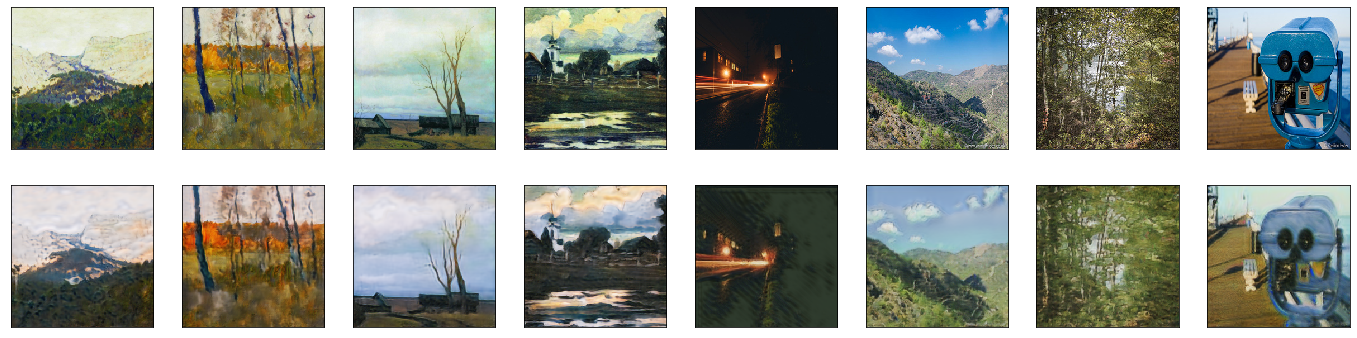

Epoch: 200. Gen loss: 5.43249218. Discr loss: 0.28348569: 100%|██████████| 200/200 [2:35:28<00:00, 46.64s/it]


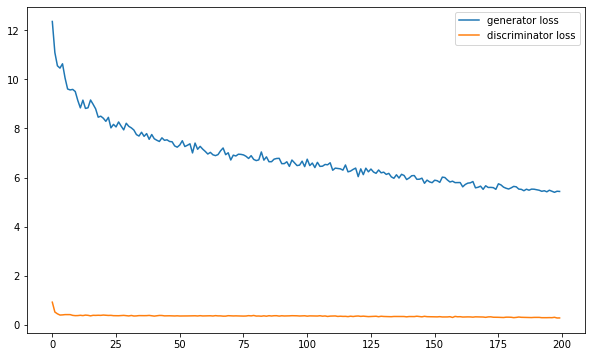

In [42]:
gan = CycleGAN(lambda: ResnetGenerator(6), PatchGAN, cycle_lambda=10, idt_lambda=5).to(device)

losses = fit(gan, loader_A, loader_B, test_loader_A, test_loader_B, 200)

torch.save(gan, 'gan_128_rc_200_resnet_6_cl_10_id_5.pkl')

plot_history(*losses)

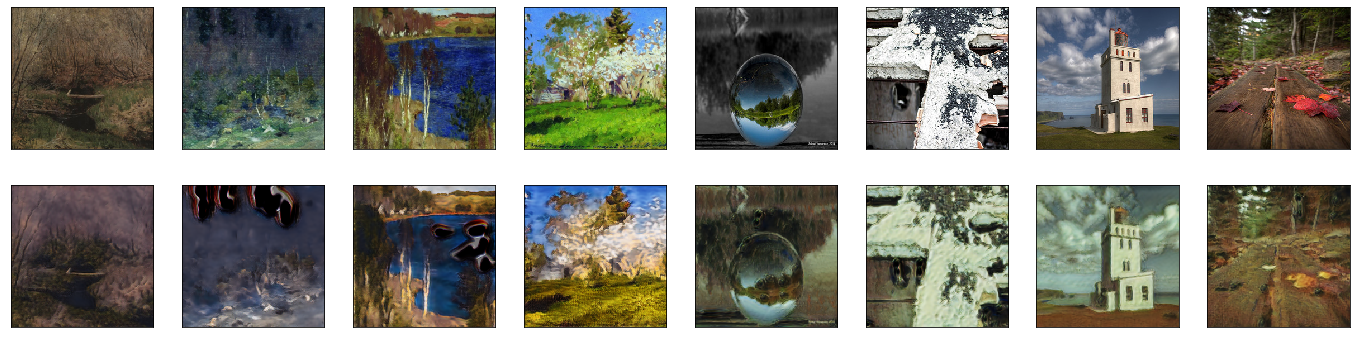

Epoch: 200. Gen loss: 3.01484127. Discr loss: 0.30199073: 100%|██████████| 200/200 [2:33:19<00:00, 46.00s/it]


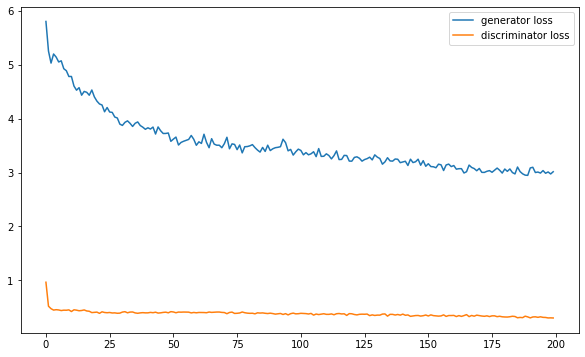

In [16]:
gan = CycleGAN(lambda: ResnetGenerator(6), PatchGAN, cycle_lambda=5, idt_lambda=1).to(device)

losses = fit(gan, loader_A, loader_B, test_loader_A, test_loader_B, 200)

torch.save(gan, 'gan_128_rc_200_resnet_6_cl_5_id_1.pkl')

plot_history(*losses)

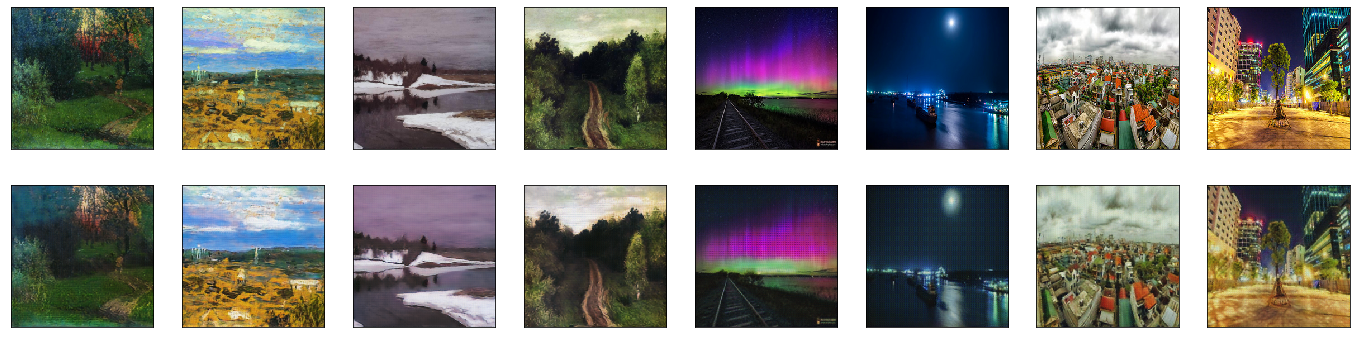

Epoch: 200. Gen loss: 4.51789131. Discr loss: 0.34994425: 100%|██████████| 200/200 [2:26:35<00:00, 43.98s/it]


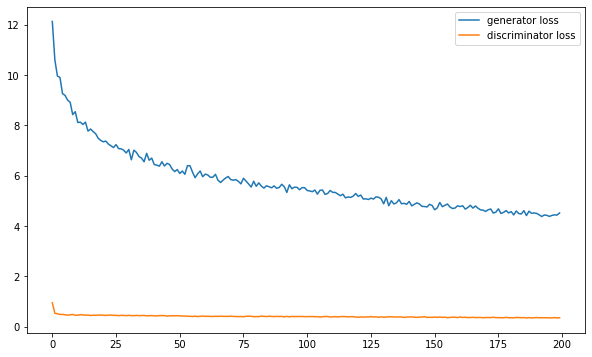

In [23]:
gan = CycleGAN(lambda: ResnetGenerator(6), PatchGAN, cycle_lambda=10, idt_lambda=5).to(device)

losses = fit(gan, loader_A, loader_B, test_loader_A, test_loader_B, 200)

torch.save(gan, 'gan_128_rc_200_resnet_6_cl_10_id_5_convtranspose.pkl')

plot_history(*losses)

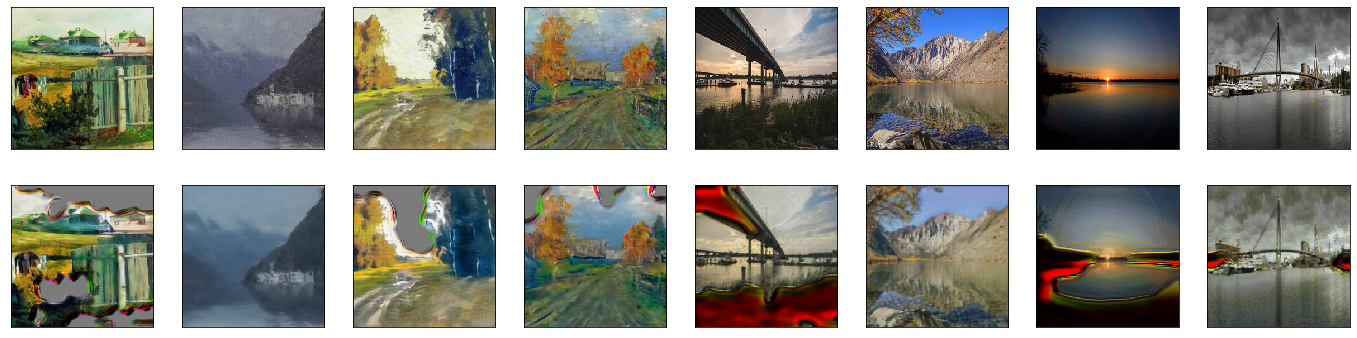

Epoch: 400. Gen loss: 5.42081763. Discr loss: 0.20799481: 100%|██████████| 400/400 [5:07:20<00:00, 46.10s/it]


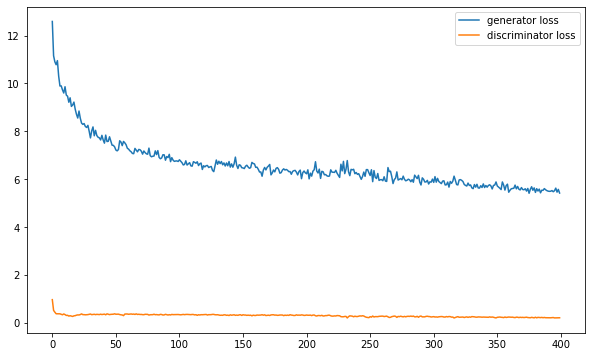

In [18]:
gan = CycleGAN(lambda: ResnetGenerator(6), PatchGAN, cycle_lambda=10, idt_lambda=5).to(device)

losses = fit(gan, loader_A, loader_B, test_loader_A, test_loader_B, 400)

torch.save(gan, 'gan_128_rc_400_resnet_6_cl_10_id_5.pkl')

plot_history(*losses)

## Тестирование

In [20]:
def plot_results(gan, test_loader_A, test_loader_B):
    test_A = next(iter(test_loader_A)).to(device)
    test_B = next(iter(test_loader_B)).to(device)
    gan.eval()
    with torch.no_grad():
        fake_A, fake_B = gan(test_A, test_B)
        plot_images([*test_A.cpu(), *test_B.cpu(), *fake_B.detach().cpu(), *fake_A.detach().cpu()], w=test_loader_A.batch_size*2, h=2)

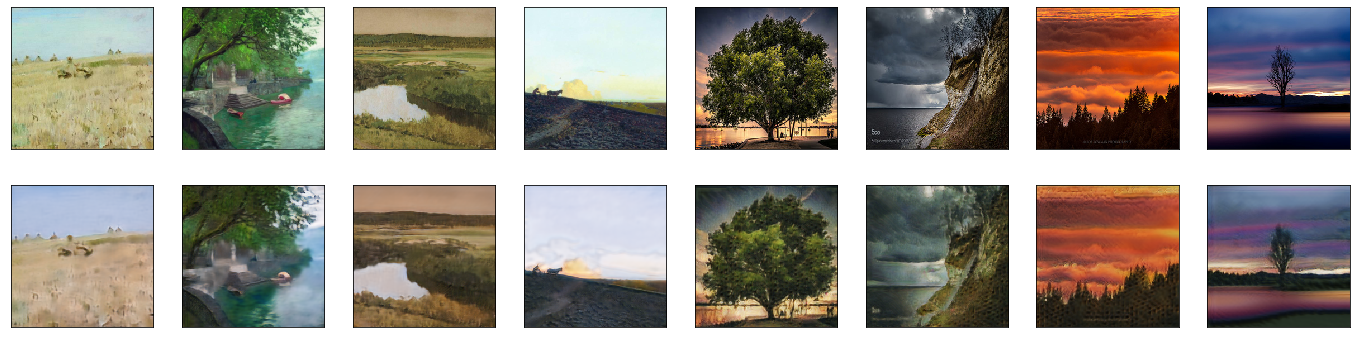

In [48]:
plot_results(torch.load('gan_128_rc_200_resnet_6_cl_10_id_5.pkl', map_location=device), test_loader_A, test_loader_B)
# plot_results(gan, test_loader_A, test_loader_B)

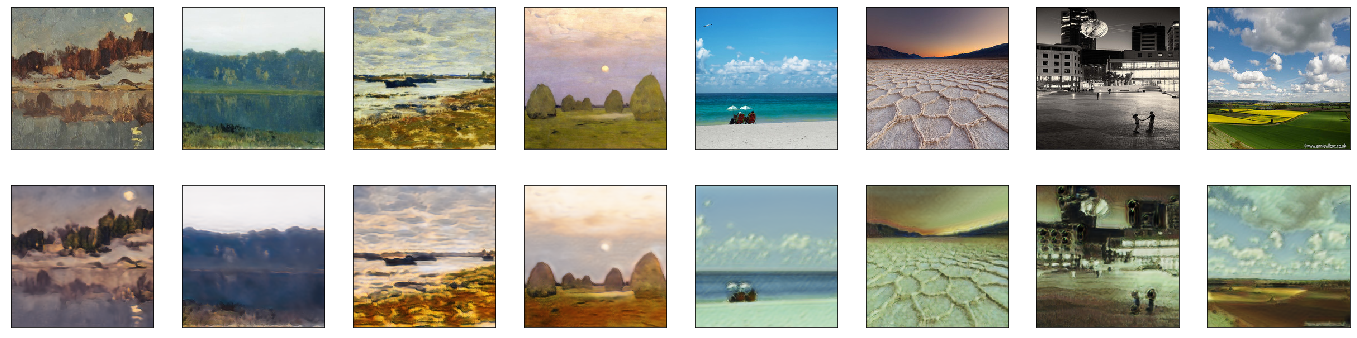

In [21]:
# plot_results(torch.load('gan_128_rc_200_resnet_6_cl_5_id_1.pkl', map_location=device), test_loader_A, test_loader_B)
plot_results(gan, test_loader_A, test_loader_B)

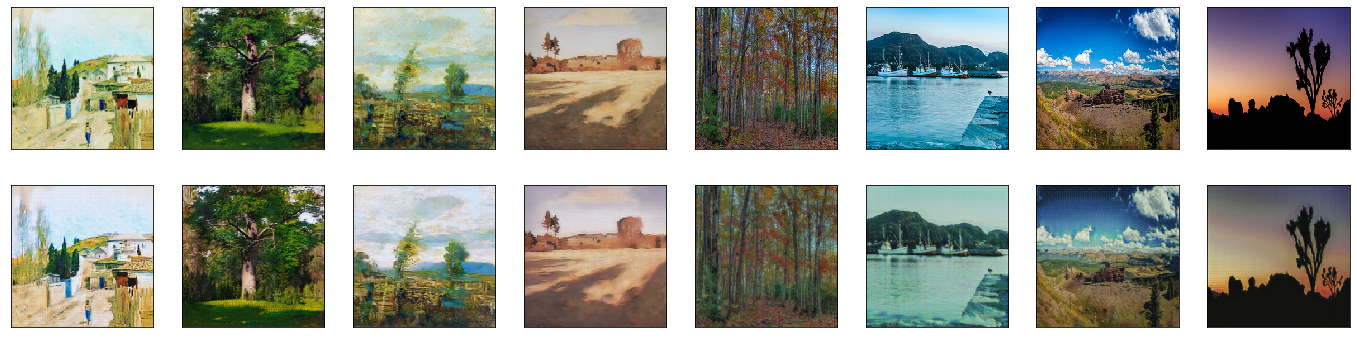

In [25]:
# plot_results(torch.load('gan_128_rc_200_resnet_6_cl_10_id_5_convtranspose.pkl', map_location=device), test_loader_A, test_loader_B)
plot_results(gan, test_loader_A, test_loader_B)

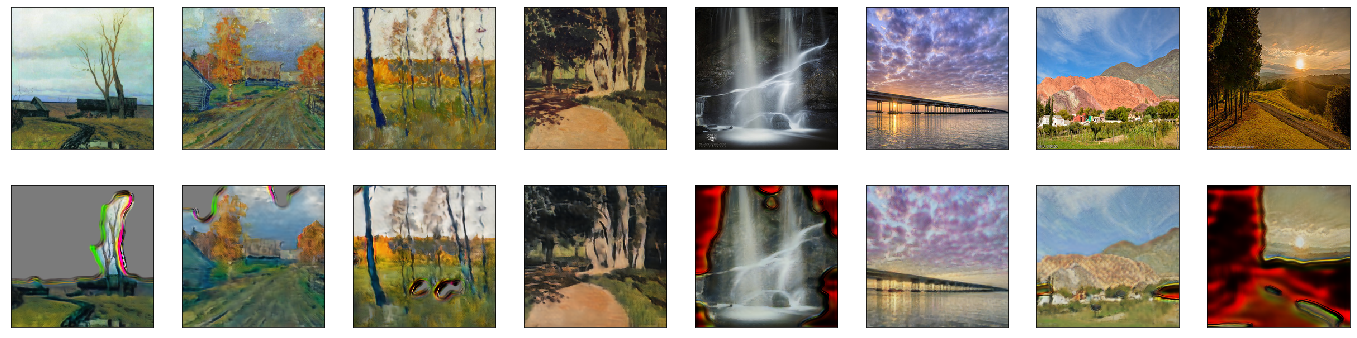

In [21]:
# plot_results(torch.load('gan_128_rc_400_resnet_6_cl_10_id_5.pkl', map_location=device), test_loader_A, test_loader_B)
plot_results(gan, test_loader_A, test_loader_B)